## Import packages

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## Samples and hyperparameters

In [2]:
n_samples = 200
learning_rate = 0.1
n_epochs = 30000

## Set up network layers "arbitrarily"

In [3]:
input_neurons = 1
output_neurons = 1
hidden_neurons = 10
hidden_layers = 3
layers = [input_neurons] + hidden_layers*[hidden_neurons] + [output_neurons]

## View layers

In [4]:
layers

[1, 10, 10, 10, 1]

## What do the layers tell us about the shape of the input array?

$$ z_{L} = \sigma(a_{L-1}W_{L} + b) $$
$$ \implies dim(col(a_{L-1})) = dim(row(W_{L})) $$
$$ \implies dim(col(a_{0})) = dim(row(W_{1})) $$
$$ \implies \text{number of columns in input array} = \text{number of input neurons} = 1 $$
$$ \implies \text{input is a column vector} $$

## Generate data as column vectors

In [5]:
x_samples = jnp.linspace(0, 2*jnp.pi).reshape(-1, 1)
y_samples = jnp.sin(x_samples)

## View shape to check that column vectors have been created

In [6]:
x_samples.shape

(50, 1)

## Plot data

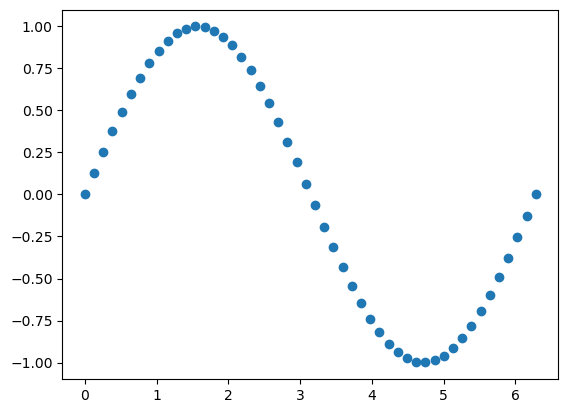

In [7]:
plt.scatter(x_samples, y_samples)

## The basics of "zip" in Python

In [8]:
list_1 = [1, 2, 3]
list_2 = ['a', 'b', 'c']
zipped = zip(list_1, list_2)

In [9]:
zipped

In [10]:
type(zipped)

zip

In [11]:
list_zipped = list(zipped)

In [12]:
list_zipped

[(1, 'a'), (2, 'b'), (3, 'c')]

1. zip in Python returns an iterator of tuples
2. in the example above, we iterate over two lists, collect the corresponding elements, pack them into a tuple, store them in the iterator
3. we convert to list to view the result

## The basics of the "lambda" function in Python

In [13]:
trial_num = 5
squared_num = lambda y:jnp.square(y)
print(squared_num(trial_num))

25


1. the "lambda" function is an anonymous function in Python
2. anonymous functions are "one-liners" that are not defined using the keyword "def"
3. anonymous functions are defined using the keyword "lambda" and are of the form "lambda argument: expression"

## Function to initialize weights and biases

In [14]:
def weights_and_biases_init(fan_in, fan_out):

    key = jax.random.PRNGKey(42)
    
    kernel_matrix_uniform_limit = jnp.sqrt(6 / (fan_in + fan_out))

    key, wkey = jax.random.split(key)

    W = jax.random.uniform(
        wkey,
        (fan_in, fan_out),
        minval=-kernel_matrix_uniform_limit,
        maxval=+kernel_matrix_uniform_limit
    )

    b = jnp.zeros(fan_out)
    
    return W, b

## Initialize weights and biases

In [15]:
weight_matrices = []
bias_vectors = []
activation_functions = []

for (dim_in, dim_out) in zip(layers[:-1], layers[1:]):
    
    W, b = weights_and_biases_init(dim_in, dim_out)

    weight_matrices.append(W)
    bias_vectors.append(b)
    activation_functions.append(jax.nn.sigmoid)

activation_functions[-1] = lambda x:x

## Define forward pass

In [16]:
def forward_pass(x, weights, biases, activations):
    
    feedforward_val = x
    
    for W, b, f in zip(weights, biases, activations):

        feedforward_val = f(jnp.matmul(feedforward_val, W) + b)

    return feedforward_val

## Generate initial prediction

In [17]:
initial_pred = forward_pass(x_samples, weight_matrices, bias_vectors, activation_functions)

## Plot initial prediction and data

Text(0.5, 1.0, 'Sine wave regression in JAX')

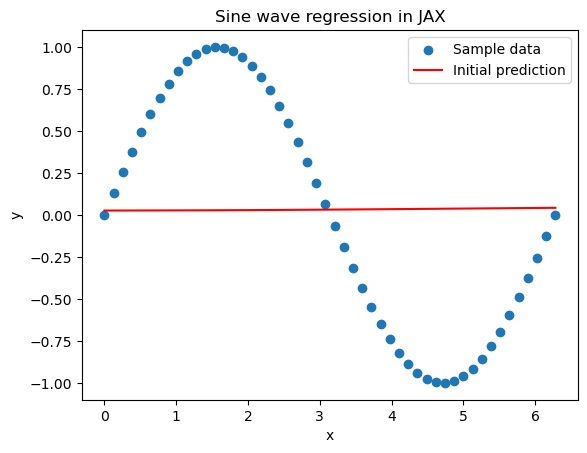

In [18]:
plt.figure()
plt.scatter(x_samples, y_samples, label="Sample data")
plt.plot(x_samples, initial_pred, 'r', label="Initial prediction")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine wave regression in JAX')

## Define MSE Loss

In [19]:
def mse_loss(y_pred, y_true):
    delta_val = y_pred - y_true
    loss_val = 0.5 * jnp.mean(jnp.square(delta_val))
    return loss_val

## Compute and print initial MSE loss

In [20]:
initial_loss = mse_loss(initial_pred, y_samples)
print(initial_loss)

0.2482953


## Autograd machine

In [21]:
loss_and_grad_fun = jax.value_and_grad(
    lambda w_current, b_current: mse_loss(
        forward_pass(
            x_samples,
            w_current,
            b_current,
            activation_functions),
        y_samples),
    argnums = (0,1)
)

1. The value and grad function available in jax provides the value of a function and its gradients with respect to its arguments
2. Here the lambda function is used to cleverly define the arguments as the weights and biases meaning that the gradients will be computed with respect to the weights and biases
3. The function is the MSE loss
4. In summary, this block provides the MSE loss and its gradients with respect to the weights and biases

## Query Autograd machine at initial step

In [22]:
loss_initial, (weight_grad_initial, bias_grad_initial) = loss_and_grad_fun(weight_matrices, bias_vectors)

In [23]:
loss_initial

Array(0.2482953, dtype=float32)

In [24]:
weight_grad_initial

[Array([[-5.7278521e-04,  2.9604454e-03, -5.8229445e-03,  6.3339151e-03,
          7.9946499e-03,  6.2230456e-04, -2.0788228e-03, -7.3708122e-04,
          2.4465867e-04,  5.4656710e-05]], dtype=float32),
 Array([[ 7.82663526e-04, -1.95341907e-03, -1.69083243e-03,
         -5.08775644e-04, -4.21083707e-04, -1.40935509e-03,
          1.51265727e-03,  1.91738538e-04,  1.14626973e-03,
         -1.69089937e-03],
        [-6.77422562e-04,  1.31621130e-03,  1.20732107e-03,
          3.49893933e-04,  2.65414739e-04,  9.99936019e-04,
         -1.13460934e-03, -1.48558232e-04, -7.86996214e-04,
          1.28003291e-03],
        [ 2.24841089e-04, -7.31522392e-04, -6.02507440e-04,
         -1.87226920e-04, -1.65938967e-04, -5.04652387e-04,
          5.13616716e-04,  6.29426213e-05,  4.22643992e-04,
         -5.68887161e-04],
        [-9.71873756e-04,  1.98106770e-03,  1.79559039e-03,
          5.24332572e-04,  4.05260187e-04,  1.48892601e-03,
         -1.67088269e-03, -2.17415814e-04, -1.17985078

In [25]:
bias_grad_initial

[Array([-1.2448383e-03, -2.5846006e-05,  6.8150926e-05, -5.3788070e-04,
        -8.5937791e-05, -9.3755079e-06, -2.9819203e-05,  1.2608065e-04,
        -2.1256245e-05,  1.3015092e-04], dtype=float32),
 Array([-4.7012069e-04,  6.2442105e-04,  6.3994201e-04,  1.7308979e-04,
         1.0784040e-04,  5.2448735e-04, -6.5299729e-04, -8.9723326e-05,
        -3.8782414e-04,  7.4704969e-04], dtype=float32),
 Array([-0.00415516,  0.00116833, -0.00098845,  0.00210902,  0.00114627,
         0.00125292, -0.00051599,  0.00268756,  0.001583  , -0.00475961],      dtype=float32),
 Array([0.03255913], dtype=float32)]

## Improve speed by using "just in time" (jit) compiler

In [26]:
loss_and_grad_fun = jax.jit(loss_and_grad_fun)

## Note on "tree map" in jax

1. PyTrees is a collection of arrays that jax understands
2. The weights and biases are nothing but such a collection of arrays
3. The PyTree line of code creates a new collection of arrays for the weights and biases and "overwrites" the old one

## Note on "fstring" in Python

fstring in Python stands for "formatted string" in Python and is a way to embed expressions into strings

## Train network via "vanilla" gradient descent

In [27]:
loss_history = []

for epoch in range(n_epochs):
    
    loss_epoch, (weight_grad_epoch, bias_grad_epoch) = loss_and_grad_fun(weight_matrices, bias_vectors)

    weight_matrices = jax.tree.map(
        lambda W, W_grad: W - learning_rate * W_grad,
        weight_matrices,
        weight_grad_epoch
    )

    bias_matrices = jax.tree.map(
        lambda b, b_grad: b - learning_rate * b_grad,
        bias_vectors,
        bias_grad_epoch
    )

    if epoch % 100 == 0:  
        print(f"epoch: {epoch}, loss:{loss_epoch}")

    loss_history.append(loss_epoch)

epoch: 0, loss:0.24829530715942383
epoch: 100, loss:0.2446155548095703
epoch: 200, loss:0.24147287011146545
epoch: 300, loss:0.23771895468235016
epoch: 400, loss:0.2324424684047699
epoch: 500, loss:0.2243163287639618
epoch: 600, loss:0.21149826049804688
epoch: 700, loss:0.19194431602954865
epoch: 800, loss:0.16540618240833282
epoch: 900, loss:0.13712085783481598
epoch: 1000, loss:0.11619126051664352
epoch: 1100, loss:0.10520493984222412
epoch: 1200, loss:0.10010659694671631
epoch: 1300, loss:0.09754494577646255
epoch: 1400, loss:0.09606106579303741
epoch: 1500, loss:0.0950649231672287
epoch: 1600, loss:0.09430085867643356
epoch: 1700, loss:0.09364932775497437
epoch: 1800, loss:0.09305062890052795
epoch: 1900, loss:0.09247355908155441
epoch: 2000, loss:0.09190134704113007
epoch: 2100, loss:0.09132519364356995
epoch: 2200, loss:0.09074068069458008
epoch: 2300, loss:0.09014592319726944
epoch: 2400, loss:0.08954042196273804
epoch: 2500, loss:0.08892440795898438
epoch: 2600, loss:0.08829837

## Plot loss history (log scale)

Text(0.5, 1.0, 'Loss history on log scale')

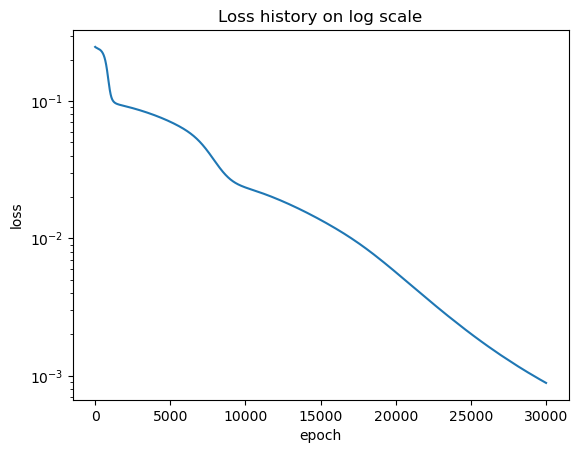

In [28]:
plt.figure()
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss history on log scale')

## Generate final predictions

In [29]:
final_pred = forward_pass(x_samples, weight_matrices, bias_vectors, activation_functions)

## Plot final prediction and data

Text(0.5, 1.0, 'Sine wave regression in JAX')

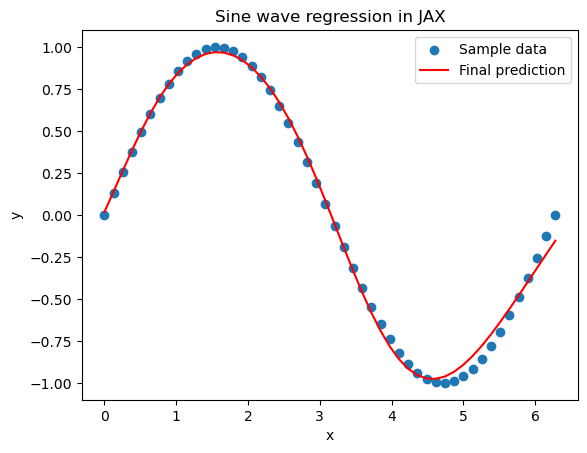

In [30]:
plt.figure()
plt.scatter(x_samples, y_samples, label="Sample data")
plt.plot(x_samples, final_pred, 'r', label="Final prediction")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine wave regression in JAX')